##### Copyright 2020 The TensorFlow IO Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 音声データの準備と拡張

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/io/tutorials/audio"><img src="https://www.tensorflow.org/images/tf_logo_32px.png"> TensorFlow.orgで表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/io/tutorials/audio.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png"> Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/io/tutorials/audio.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示{</a></td>
      <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/io/tutorials/audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード/a0}</a></td>
</table>

## 概要

自動音声認識における大きな課題の 1 つは、音声データの準備と拡張です。音声データ分析は、時間または周波数領域にあり可能性があるため、画像などのほかのデータソースと比べさらに複雑化します。

TensorFlow エコシステムの一環として、`tensorflow-io` パッケージには、多数の有用な音声関連の API が提供されており、音声データの準備と拡張を単純化することができます。

## セットアップ

### 必要なパッケージをインストールし、ランタイムを再起動する

In [2]:
!pip install -q tensorflow-io

## 使用方法

### 音声ファイルを読み取る

TensorFlow IO では、クラス `tfio.audio.AudioIOTensor` を使用して、音声ファイルを遅延読み込みされる `IOTensor` に読み出すことができます。

In [3]:
import tensorflow as tf
import tensorflow_io as tfio

audio = tfio.audio.AudioIOTensor('gs://cloud-samples-tests/speech/brooklyn.flac')

print(audio)

<AudioIOTensor: shape=[28979     1], dtype=<dtype: 'int16'>, rate=16000>


上記の例の Flac ファイル `brooklyn.flac` は、[google cloud](https://cloud.google.com/speech-to-text/docs/quickstart-gcloud) でパブリックアクセスが可能な音声クリップから得たものです。

GCS は TensorFlow でサポートされているファイルシステムであるため、GCS アドレス `gs://cloud-samples-tests/speech/brooklyn.flac` が直接使用されています。`Flac` 形式のほか、`WAV`、`Ogg`、`MP3`、および `MP4A` 形式も `AudioIOTensor` の自動ファイル形式検出でサポートされています。

`AudioIOTensor` は遅延読み込みされるため、最初は形状、dtype、およびサンプルレートしか表示されません。`AudioIOTensor` の形状は `[samples, channels]` で表現され、読み込んだ音声クリップが `int16` 型の `28979` サンプルを含む Mono チャンネルであることを示します。

音声クリップのコンテンツは、`to_tensor()` 経由で `AudioIOTensor` から `Tensor` に変換するか、スライスによって、必要に応じてのみ読み取られます。スライスは、特に大きな音声クリップのほんの一部のみが必要である場合に役立ちます。

In [4]:
audio_slice = audio[100:]

# remove last dimension
audio_tensor = tf.squeeze(audio_slice, axis=[-1])

print(audio_tensor)

tf.Tensor([16 39 66 ... 56 81 83], shape=(28879,), dtype=int16)


次のようにして、音声を再生できます。

In [5]:
from IPython.display import Audio

Audio(audio_tensor.numpy(), rate=audio.rate.numpy())

テンソルを浮動小数点数に変換して音声クリップをグラフに表示するとより便利です。

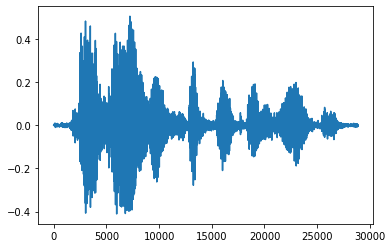

In [6]:
import matplotlib.pyplot as plt


tensor = tf.cast(audio_tensor, tf.float32) / 32768.0

plt.figure()
plt.plot(tensor.numpy())

### ノイズをトリムする

音声からノイズを取り除く方が好ましい場合があります。これは、API `tfio.experimental.audio.trim` を使用して行います。API から戻されるのは、セグメントの `[start, stop]` 位置のペアです。

tf.Tensor([ 2398 23546], shape=(2,), dtype=int64)
tf.Tensor(2398, shape=(), dtype=int64) tf.Tensor(23546, shape=(), dtype=int64)


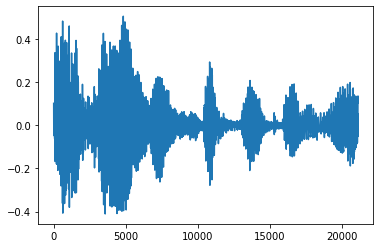

In [7]:
position = tfio.experimental.audio.trim(tensor, axis=0, epsilon=0.1)
print(position)

start = position[0]
stop = position[1]
print(start, stop)

processed = tensor[start:stop]

plt.figure()
plt.plot(processed.numpy())

### フェードインとフェードアウト

音声エンジニアリングの有用なテクニックには、フェードという、音声信号を徐々に増加または減少させるものがあります。これは、`tfio.experimental.audio.fade` を使用して行います。`tfio.experimental.audio.fade` は、`linear`、`logarithmic`、または `exponential` などのさまざまな形状のフェードをサポートしています。

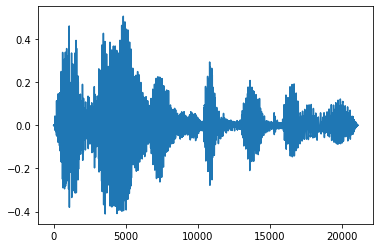

In [8]:
fade = tfio.experimental.audio.fade(
    processed, fade_in=1000, fade_out=2000, mode="logarithmic")

plt.figure()
plt.plot(fade.numpy())

### スペクトログラム

多くの場合、高度な音声処理は、時間の経過に伴う周波数の変化に対応します。`tensorflow-io` では、`tfio.experimental.audio.spectrogram` を使って波形を変換することができます。

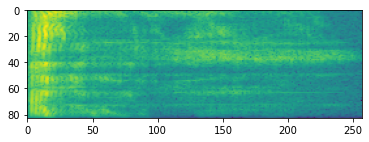

In [9]:
# Convert to spectrogram
spectrogram = tfio.experimental.audio.spectrogram(
    fade, nfft=512, window=512, stride=256)

plt.figure()
plt.imshow(tf.math.log(spectrogram).numpy())

異なるスケールへの追加の変換も可能です。

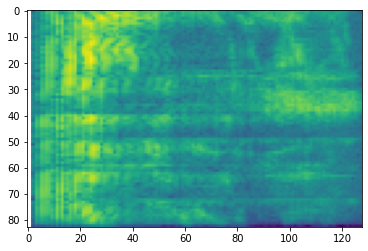

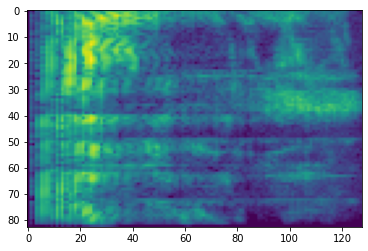

In [10]:
# Convert to mel-spectrogram
mel_spectrogram = tfio.experimental.audio.melscale(
    spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)


plt.figure()
plt.imshow(tf.math.log(mel_spectrogram).numpy())

# Convert to db scale mel-spectrogram
dbscale_mel_spectrogram = tfio.experimental.audio.dbscale(
    mel_spectrogram, top_db=80)

plt.figure()
plt.imshow(dbscale_mel_spectrogram.numpy())

### SpecAugment

上述したデータの準備と拡張 API のほか、`tensorflow-io` パッケージには、高度なスペクトログラムの拡張、特に [SpecAugment: A Simple Data Augmentation Method for Automatic Speech Recognition（Park et al., 2019）](https://arxiv.org/pdf/1904.08779.pdf)で論じられている周波数と時間のマスキングも含まれています。

#### 周波数マスキング

周波数マスキングでは、周波数チャンネルの `[f0, f0 + f)` がマスクされます。`f` は、`0` から周波数マスクパラメータ `F` までの一様分布から選択され、`f0` は、`(0, ν − f)` から選択されます。この `ν` は、周波数チャンネル数です。

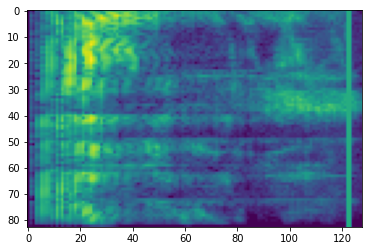

In [11]:
# Freq masking
freq_mask = tfio.experimental.audio.freq_mask(dbscale_mel_spectrogram, param=10)

plt.figure()
plt.imshow(freq_mask.numpy())

#### 時間マスキング

時間マスキングでは、`t` 個の連続した時間ステップ `[t0, t0 + t)` がマスクされます。`t` は、`0` から時間マスクパラメータ `T` までの一様分布から選択され、`t0` は、`[0, τ − t)` から選択されます。この `τ` は時間ステップ数です。

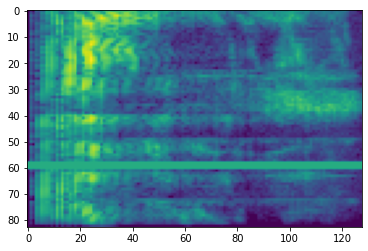

In [12]:
# Time masking
time_mask = tfio.experimental.audio.time_mask(dbscale_mel_spectrogram, param=10)

plt.figure()
plt.imshow(time_mask.numpy())